# About the notebook

The following notebook contains the Bert model with Linear layer for the classification purpose (sentiment analysis & text classification). The notebook has a following order:

1. [Data Import & Preprocess](#section_1)
2. [Tokenization & Preprocess for model](#section_2)
3. [Fine-Tuning Function](#section_3)
4. [Fine-Tuning](#section_4)
5. [Confusion matrix & Critical Error](#section_5)
6. [Train & Test](#section_6)


The purpose of this notebook is to perform a text classification of financial news article with target value of Sentiment ($positive, neutral, negative$) and Importance ($important, normal, negligible$) regarding the firm it covers. With two parameters, our team will select 15-20 firms that are worth spotlight of a day and publish a report about the firm automatically.

In this notebook, I have implemented text classification using deep learning method, and have achieved $76$% accuracy on 5-fold cv but our team focuses on what we defined as critical error.

Let $S_i,r$ be the actual sentiment of the article labeled by analyst, and $S_i,p$ be the predicted sentiment of the article by the model. Then, the critical error is defined as below:
* $Critical\enspace Error = \frac{\sum_{i=1}^{n} \mathbb{1}_\{S_i,r = positive, S_i,p\ = negative\} +  \mathbb{1}_\{S_i,r = negative, S_i,p\ = positive\}}{Total\enspace number\enspace of\enspace article}$

The sentiment can be changed to importance with $positive = importance$ and $negative = negligible$. Since the evaluation of the article might be different by analysts' perspectives, we do not like to publish a report with news tagged as negative but some view as positive. We want such report to be published as neutral. Therefore, we care more about the critical error that we have defined.

In [ ]:
#===============================================================================
# Import Libraries and Download module necessary for the deep learning
#===============================================================================

#huggingface library installation
!pip install transformers

import numpy as np
import pandas as pd
import os
from transformers import BertForTokenClassification, AdamW, BertConfig, BertForSequenceClassification, get_linear_schedule_with_warmup
import random
import transformers
from torch.utils.data import TensorDataset, random_split,DataLoader, RandomSampler, SequentialSampler
import torch.nn.functional as F
from torch.autograd import Variable
import time
import datetime
from platform import python_version
import sklearn
import torch

#Using Colab GPU for training
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

#To confirm that we are using GPU for the training later

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

     |████████████████████████████████| 778kB 4.8MB/s 
     |████████████████████████████████| 1.1MB 24.9MB/s 
     |████████████████████████████████| 890kB 40.7MB/s 
     |████████████████████████████████| 3.0MB 45.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=102aac470bb65821df8966559c22b71d4ac5195ce36fe3d4c3fcae17e2e6c579
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
Found GPU at: /device:GPU:0
There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


## 1. Data Import & Preprocess <a class="anchor" id="section_1"></a>

The original news article data sets are provided by CIMS to Korea Investment. Then, the sentiments and scores of articles are labeled by the Analysts or research assistants in Research center of Korea Investment. 0,1,2 means negative, neutral, positivie respectively for the sentiment score and 0,1,2 means, negligible, normal, important respectively for the score part. 

The summary_v1, summary_v2 columns are the summarization by the distilbert-base-uncased summarizer uploaded in the huggingface library. summary_v1 is a summarization of text column, summary_v2 is a summarization of the summary_v1 column


In [ ]:
#===============================================================================
# Load Google Drive for the data
#===============================================================================
from google.colab import drive
drive.mount('/content/drive')

file_direction = '/content/drive/My Drive/KIS data/CIMS_news_with_bertext_sum_full.xlsx'
df = pd.read_excel(file_direction)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
#===============================================================================
# Text Data & label preprocess for the model
#===============================================================================

print(len(df))
idx_to_remove = []
for i in range(len(df)):
  if type(df['summary_v2'][i]) == float:
    idx_to_remove.append(i)

df = df.iloc[list(set(df.index) - set(idx_to_remove))]
df.index = np.arange(0, len(df))
print(len(df))

df['importance'] = df['score']

#score by daumsoft:
#sentiment: 3 - positive, 2 - neutral, 1 - negative
#score: 3 - important, 2 - normal, 1 - negligible 
for i in range(len(df)):
  if df.loc[i,'sentiment'] == 3:
    df.loc[i,'sentiment'] = 2
  elif df.loc[i,'sentiment'] == 2:
    df.loc[i,'sentiment'] = 1
  elif df.loc[i,'sentiment'] == 1:
    df.loc[i,'sentiment'] = 0
  if df.loc[i, 'score'] == 1:
    df.loc[i, 'importance'] = 0
  elif df.loc[i, 'importance'] == 2:
    df.loc[i, 'importance'] = 1
  elif df.loc[i, 'importance'] == 3:
    df.loc[i, 'importance'] = 2

6584
6582


In [ ]:
#===============================================================================
# Prepare text data (Title + summary) for the model
#===============================================================================
df['title_summary'] = df['title'] + ' ' + df['summary_v2']
title_summary_len = [len(df['title_summary'][i].split(' ')) for i in range(len(df))]
df_stat = pd.DataFrame(title_summary_len)
df_stat.describe()

,0
count,6582.000000
mean,52.518839
std,17.800150
min,13.000000
25%,42.000000
50%,47.000000
75%,60.000000
max,183.000000


In [ ]:
#===============================================================================
# Data Preprocess & Distribution of labels (sentiment & importance)
#===============================================================================
X, y1, y2 = df['title_summary'], df['sentiment'], df['importance']
y1_values, y2_values = y1.values, y2.values

label_count_1, label_count_2 = [0,0,0], [0,0,0]
for i in range(len(y1)):
  label_count_1[y1_values[i]] += 1
  label_count_2[y2_values[i]] += 1

print(label_count_1, label_count_2)
print([round(label_count_1[i]/sum(label_count_1),3) for i in range(len(label_count_1))], [round(label_count_2[i]/sum(label_count_2),3) for i in range(len(label_count_2))])

[1315, 3245, 2022] [2045, 2432, 2105]
[0.2, 0.493, 0.307] [0.311, 0.369, 0.32]


In [ ]:
#===============================================================================
# In order to fine-tune BERT for the importance classification
#===============================================================================

X, y1, y2 = df['title_summary'], df['importance'], df['importance']
y1_values, y2_values = y1.values, y2.values

## 2. Tokenization & Preprocess for model <a class="anchor" id="section_2"></a>

* While the first section is for the preprocess of text data itself, this section is the preprocess for the model (BERT)
* Convert the Text according to the model input
* [huggingface.co](https://huggingface.co/models)

In [ ]:
#===============================================================================
# Download BERT tokenizer from huggingface
#===============================================================================
from transformers import *

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Print the original sentence.
print(' Original: ', X[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(X[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(X[0])))


 Original:  Google Helping Mobile Publishing? Some Publishers Are Not So Sure In October, the software developer Alex Kras created a stir when he wrote a post titled “Google May Be Stealing Your Mobile Traffic,” in which he recounted what had happened when he used AMP on his technology blog. Joey Marburger, director of products for The Post, said that its readers were scrolling further on AMP stories, but that it was building its own fast system to gain greater control over ads and features. “
Tokenized:  ['google', 'helping', 'mobile', 'publishing', '?', 'some', 'publishers', 'are', 'not', 'so', 'sure', 'in', 'october', ',', 'the', 'software', 'developer', 'alex', 'k', '##ras', 'created', 'a', 'stir', 'when', 'he', 'wrote', 'a', 'post', 'titled', '“', 'google', 'may', 'be', 'stealing', 'your', 'mobile', 'traffic', ',', '”', 'in', 'which', 'he', 'recounted', 'what', 'had', 'happened', 'when', 'he', 'used', 'amp', 'on', 'his', 'technology', 'blog', '.', 'joey', 'mar', '##burg', '##er',

In [ ]:
#===============================================================================
# In order to decide the MAX_LEN for padding and truncation purpose, check the 
# distribution of length of text data
#===============================================================================

max_len = 0
too_big_input = []
len_dist = []
for i in range(len(X)):
  input_ids = tokenizer.encode(X[i], add_special_tokens = True)
  max_len = max(len(input_ids), max_len)
  len_dist.append(len(input_ids))
  if len(input_ids) > 512:
    too_big_input.append(i)

print('Max length of title is ', max_len)
df_stat = pd.DataFrame(len_dist)
df_stat.describe()

Max length of title is  222


,0
count,6582.000000
mean,69.756913
std,23.331647
min,17.000000
25%,55.000000
50%,62.000000
75%,80.000000
max,222.000000


In [ ]:
#===============================================================================
# The preprocess code for the BERT
# The following code is from https://mccormickml.com/2019/07/22/BERT-fine-tuning/
#===============================================================================

MAX_LEN = 128


def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            sent,  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True,      # Return attention mask
            truncation = True
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

## 3. Fine-Tuning Function <a class="anchor" id="section_3"></a>

* Declare Model and train functions
* All the other notebooks follow the same procedure except this section.
* Most of the implication of the model is from this [website](https://mccormickml.com/2019/07/22/BERT-fine-tuning/). 

In [ ]:
#===============================================================================
# Declare the BERT Classifier for later train and test purpose
# if one wants to change the model, one can modify the below section
#===============================================================================

%%time
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False, layers_to_freeze = []):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 100, 3

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        else:
          if layers_to_freeze != []:
            for i in layers_to_freeze:
              for param in self.bert.encoder.layer[i].parameters():
                param.requires_grad = False
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

CPU times: user 43 µs, sys: 0 ns, total: 43 µs
Wall time: 45.3 µs


In [ ]:
#===============================================================================
# Initialize model for the later train purpose
#===============================================================================

def initialize_model(epochs=4, layers_to_freeze = []):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False, layers_to_freeze = layers_to_freeze)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=2e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [ ]:
#===============================================================================
# Train & Evaluate function 
#===============================================================================

import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")

    #return float(val_loss), float(val_accuracy)
    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

## 4. Fine-Tuning <a class="anchor" id="section_4"></a>


* Actual fine-tuning process. I have used 5-fold cv to check the overfitting. 
* If one wants to train once, please put $break$ at the end of the line.


According to the [Devlin et al., 2018](https://arxiv.org/abs/1810.04805), the following parameters' range works well across all task.
* Batch size: 16, 32
* Learning rate (Adam): 5e-5, 3e-5, 2e-5
* Number of epochs: 2,3,4

In [ ]:
#===============================================================================
# Part where we train using the 5-fold cv
#===============================================================================


from sklearn.model_selection import KFold
#train and val are indices
kf = KFold(n_splits=5, shuffle = True, random_state = 42)

batch_size = 16
train_loss = []
val_loss = []
val_accuracy = []

y1 = y1.astype(int)

for train_index, val_index in kf.split(X):
  #Data Preparation
  X_train = X[train_index]
  X_val = X[val_index]
  y1_train = y1[train_index]
  y1_val = y1[val_index]
  
  train_inputs, train_masks = preprocessing_for_bert(X_train)
  val_inputs, val_masks = preprocessing_for_bert(X_val)
  train_labels = torch.tensor(y1_train.values)
  val_labels = torch.tensor(y1_val.values)
  
  #Data Loader Class
  train_data = TensorDataset(train_inputs, train_masks, train_labels)
  train_sampler = RandomSampler(train_data)
  train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size = batch_size)

  val_data = TensorDataset(val_inputs, val_masks, val_labels)
  val_sampler = RandomSampler(val_data)
  val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size = batch_size)

  #Fine Tune and Evaluation
  set_seed(42)    # Set seed for reproducibility
  #epoch 수 조정을 통해 나은 결과가 나올 수 있습니다.
  bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
  # evaluation false라고 하면 bert_classfier는 훈련만 진행합니다.
  # 다른 노트북에서 훈련 후 예측하는 과정을 확인 할 수 있습니다.
  val_loss1, val_accuracy1 = train(bert_classifier, train_dataloader, val_dataloader, epochs=2, evaluation=True)
  
  val_loss.append(val_loss1)
  val_accuracy.append(val_accuracy1)
  break


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.986993   |     -      |     -     |   15.34  
   1    |   40    |   0.969681   |     -      |     -     |   14.27  
   1    |   60    |   0.912512   |     -      |     -     |   14.24  
   1    |   80    |   0.905262   |     -      |     -     |   14.22  
   1    |   100   |   0.885821   |     -      |     -     |   14.21  
   1    |   120   |   0.934805   |     -      |     -     |   14.21  
   1    |   140   |   0.868877   |     -      |     -     |   14.20  
   1    |   160   |   0.833068   |     -      |     -     |   14.21  
   1    |   180   |   0.843923   |     -      |     -     |   14.20  
   1    |   200   |   0.801833   |     -      |     -     |   14.17  
   1    |   220   |   0.747846   |     -      |     -     |   14.23  
   1    |   240   |   0.767086   |     -      |     -     |   14.20  

In [ ]:
#===============================================================================
# Print the mean loss and accuracy of the 5-fold cv
#===============================================================================
print('The mean validation accuracy of 5-fold cv is: ',np.mean(val_accuracy))
print('The mean validation loss of 5-fold cv is: ', np.mean(val_loss))

The mean validation accuracy of 5-fold cv is:  64.17168674698796
The mean validation loss of 5-fold cv is:  0.7849277178925204


## 5. Confusion matrix & Critical Error <a class="anchor" id="section_5"></a>



In [ ]:
#===============================================================================
# Prediction function given the fine-tuned model
#===============================================================================
def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()
    val_accuracy = []
    all_pred = []
    all_real = []
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)
        all_real.append(b_labels)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)


        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()
        all_pred.append(preds)

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    all_real = torch.cat(all_real)
    all_pred = torch.cat(all_pred)
    # Compute the average accuracy and loss over the validation set.
    #val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_accuracy,all_real, all_pred

In [ ]:
#===============================================================================
# Import py file for confusion matrtix
#===============================================================================
import sys
import os
py_file_location ='/content/drive/My Drive/Lib'
sys.path.append(py_file_location)

from confusion_matrix import *

In [ ]:
#===============================================================================
# Make prediction for confusion matrix and critical error
#===============================================================================
acc,all_real, all_pred = bert_predict(bert_classifier, val_dataloader)

critical_error = 0
crit_error_index = []
hit = 0
for i in range(len(all_real)):
  if all_real[i] == all_pred[i]:
    hit += 1
  if abs(all_pred[i] - all_real[i]) == 2:
    critical_error += 1
    crit_error_index.append(i)

all_pred = all_pred.cpu().numpy()
all_real = all_real.cpu().numpy()

print('The accuracy of the model is :', hit/len(all_real))
print('The critical error is : ',critical_error/len(all_real))

The accuracy of the model is : 0.6454062262718299
The critical error is :  0.04176157934700076


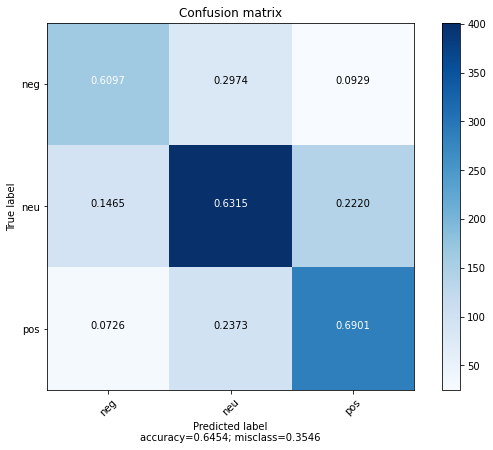

In [ ]:
#===============================================================================
# Visualization of Confusion matrix
#===============================================================================
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(all_real, all_pred)
plot_confusion_matrix(cm,
                      ['neg','neu', 'pos'],
                      title='Confusion matrix',
                      cmap=None,
                      normalize=True)

## Train & Test <a class="anchor" id="section_6"></a>

In [ ]:
#===============================================================================
# import py for the EDA (Easy data Augmentation)
# original code from https://github.com/jasonwei20/eda_nlp
#===============================================================================
import sys
import os
py_file_location ='/content/drive/My Drive/Lib'
sys.path.append(py_file_location)

from easy_data_augmentation import *
from confusion_matrix import *

X, y1 = gen_eda(X, y1, alpha = 0.2, num_aug = 6)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
#===============================================================================
# Train for prediction
#===============================================================================

batch_size = 64
train_loss = []
val_loss = []
val_accuracy = []
layers_to_freeze = [0,1,2,3,4,5,6,7]


train_inputs, train_masks = preprocessing_for_bert(X)
train_labels = torch.tensor(y1)
#Data Loader Class
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size = batch_size)

set_seed(42)
bert_classifier, optimizer, scheduler = initialize_model(epochs=4, layers_to_freeze = layers_to_freeze)
train(bert_classifier, train_dataloader, epochs=4, evaluation=False)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   1.087327   |     -      |     -     |   11.79  
   1    |   40    |   1.046919   |     -      |     -     |   11.22  
   1    |   60    |   1.022933   |     -      |     -     |   11.21  
   1    |   80    |   0.980157   |     -      |     -     |   11.22  
   1    |   100   |   0.971398   |     -      |     -     |   11.23  
   1    |   120   |   0.948139   |     -      |     -     |   11.22  
   1    |   140   |   0.930331   |     -      |     -     |   11.22  
   1    |   160   |   0.947995   |     -      |     -     |   11.22  
   1    |   180   |   0.906548   |     -      |     -     |   11.23  
   1    |   200   |   0.914452   |     -      |     -     |   11.24  
   1    |   220   |   0.880794   |     -      |     -     |   11.23  
   1    |   240   |   0.879363   |     -      |     -     |   11.23  


In [ ]:
#===============================================================================
# Test the trained model
#===============================================================================

df_test = pd.read_json('/content/drive/My Drive/KIS data/test_data.json')

print(len(df_test))
idx_to_remove = []
for i in range(len(df_test)):
  if type(df_test['summary'][i]) == float:
    idx_to_remove.append(i)
  if type(df_test['title'][i]) == float:
    idx_to_remove.append(i)

df_test = df_test.iloc[list(set(df_test.index) - set(idx_to_remove))]
df_test.index = np.arange(0, len(df_test))
print(len(df_test))



df_test['title_summary'] = df_test['title'] + ' ' + df_test['summary']
df_test= df_test.drop(df_test[df_test['title_summary'].isnull()].index)
df_test.index = np.arange(0, len(df_test))
df_test= df_test.drop(df_test[df_test['importance'].isnull()].index)
df_test.index = np.arange(0, len(df_test))
df_test= df_test.drop(df_test[df_test['sentiment'].isnull()].index)
df_test.index = np.arange(0, len(df_test))
title_summary_len = [len(df_test['title_summary'][i].split(' ')) for i in range(len(df_test))]
df_stat = pd.DataFrame(title_summary_len)
df_stat.describe()


X_test, y1_test, y2_test = df_test['title_summary'], df_test['sentiment'].apply(int), df_test['importance'].apply(int)
y1_test_values, y2_test_values = y1_test.values, y2_test.values

label_count_test_1, label_count_test_2 = [0,0,0], [0,0,0]
for i in range(len(y1_test)):
  label_count_test_1[y1_test_values[i]] += 1
  label_count_test_2[y2_test_values[i]] += 1

print(label_count_test_1, label_count_test_2)
print([round(label_count_test_1[i]/sum(label_count_test_1),3) for i in range(len(label_count_test_1))], [round(label_count_test_2[i]/sum(label_count_test_2),3) for i in range(len(label_count_test_2))])

2898
2898
[366, 1585, 915] [1052, 918, 896]
[0.128, 0.553, 0.319] [0.367, 0.32, 0.313]


In [ ]:
#===============================================================================
# Make prediction on test data
#===============================================================================
test_inputs, test_masks = preprocessing_for_bert(X_test)
test_labels = torch.tensor(y1_test)
#Data Loader Class
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler = test_sampler, batch_size = batch_size)

acc,all_real, all_pred = bert_predict(bert_classifier, test_dataloader)

critical_error = 0
crit_error_index = []
hit = 0
for i in range(len(all_real)):
  if all_real[i] == all_pred[i]:
    hit += 1
  if abs(all_pred[i] - all_real[i]) == 2:
    critical_error += 1
    crit_error_index.append(i)

all_pred = all_pred.cpu().numpy()
all_real = all_real.cpu().numpy()

print('The accuracy of the model is :', hit/len(all_real))
print('The critical error is : ',critical_error/len(all_real))

The accuracy of the model is : 0.31751570132588974
The critical error is :  0.15247732030704816


In [ ]:
#===============================================================================
# Visualization of confusion matrix
#===============================================================================
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(all_real, all_pred)
plot_confusion_matrix(cm,
                      ['neg','neu', 'pos'],
                      title='Confusion matrix',
                      cmap=None,
                      normalize=True)